In [1]:
# импорт библиотек
from sklearn import svm
from sklearn import datasets, linear_model, metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.neighbors import KNeighborsClassifier
import pylab as pl
import numpy as np
from xgboost import XGBClassifier
from xgboost import plot_importance
import pandas as pd
from pandas import read_csv, DataFrame, Series
import matplotlib.pyplot as plt

In [2]:
path = 'data\\domains\\'

In [3]:
colnames=['txt']
# Загрузка справочника телефонов
df = pd.read_csv(path+'phone_numbers.csv', encoding='utf-8', names=colnames, nrows=3000, skiprows=1)
df['target']='phone'
df.to_csv(path+'fsht.csv', index=False)
# Загрузка справочника имен
df_temp = pd.read_csv(path+'names.csv', encoding='utf-8', nrows=3000, usecols = ['name'])
df_temp['target']='name'
df_temp.to_csv(path+'fsht.csv', index=False, mode='a', header=False)
# Загрузка справочника фамилий
df_temp = pd.read_csv(path+'surnames.csv', encoding='utf-8', nrows=3000, usecols = ['surname'])
df_temp['target']='surname'
df_temp.to_csv(path+'fsht.csv', index=False, mode='a', header=False)
# Загрузка справочника отчеств
df_temp = pd.read_csv(path+'midnames.csv', encoding='utf-8', nrows=3000, usecols = ['midname'])
df_temp['target']='midname'
df_temp.to_csv(path+'fsht.csv', index=False, mode='a', header=False)
# Загрузка справочника ФИО
df_temp = pd.read_csv(path+'fio.csv', encoding='utf-8', nrows=3000, usecols = ['fio'])
df_temp['target']='fio'
df_temp.to_csv(path+'fsht.csv', index=False, mode='a', header=False)
#
df_temp = pd.read_csv(path+'others_table_2.csv', encoding='utf-8', nrows=500, sep=';')
df_temp['target']='other'

for column in df_temp.columns:
    df_temp.loc[df_temp[column] != 0.0].to_csv(path + 'fsht.csv', index=False, mode='a', header=False, columns=[column, 'target'])

In [4]:
def prepare_data(df):
    df['txt']=df['txt'].str.lower()
    df['len']=df.txt.str.len()
    #df['digits_len'] = df.txt.map(lambda x: len([k for k in x if k.isdigit()]))
    df['digits_len'] = df.txt.str.count('[0-9]')
    #df['alpha_len'] = df.txt.map(lambda x: len([k for k in x if k.isalpha()]))
    df['alpha_len'] = df.txt.str.count('[A-Za-zА-Яа-яЁё]')
    df['dot_len']=df.txt.str.count('\.')
    df['space_len']=df.txt.str.count(' ')
    df['dash_len']=df.txt.str.count('\-')
    df['plus_len']=df.txt.str.count('\+')
    df['comma_len']=df.txt.str.count(',')    
    df['bracket']=df.txt.str.count('[()]')
    df['midname_ending'] = 0
    df.loc[df['txt'].str[-3:].isin(['вич','вна']) , 'midname_ending'] = 1
    df['name_ending'] = 0
    df.loc[df['txt'].str[-2:].isin(['ов','ев']) , 'name_ending'] = 1    
    df.loc[df['txt'].str[-3:].isin(['ова','ева']) , 'name_ending'] = 1 
    df = df.drop(['txt'], axis=1)
    return df

In [5]:
# Считываем данные
train_data = pd.read_csv(path+'fsht.csv', encoding='utf-8')
train_data = train_data.drop_duplicates(subset=['txt', 'target'], keep=False) 
test_data = pd.read_csv("data\\test.csv", encoding='utf8', sep=',')

In [6]:
X_train = train_data.copy()
X_test = test_data.copy()
X_train = prepare_data(X_train)
X_test = prepare_data(X_test)

In [7]:
#y_train = X_train['target']
y_train = pd.get_dummies(train_data, columns=['target'])
X_train = X_train.drop(['target'], axis=1)

In [8]:
state = 12  
test_size = 0.4 

ROCtrainTRN, ROCvalTRN, ROCtrainTRG, ROCvalTRG = train_test_split(X_train, y_train,  
    test_size=test_size, random_state=state)

In [9]:
y_train = y_train.drop(['txt'], axis=1)
result=pd.DataFrame()
result['txt']=test_data['txt']

Learning :  target_fio
Accuracy score (validation): 1.000


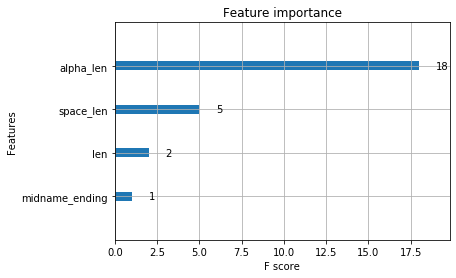

Learning :  target_midname
Accuracy score (validation): 0.998


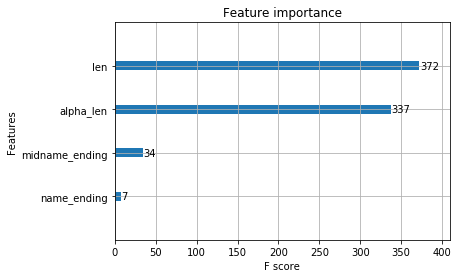

Learning :  target_name
Accuracy score (validation): 0.947


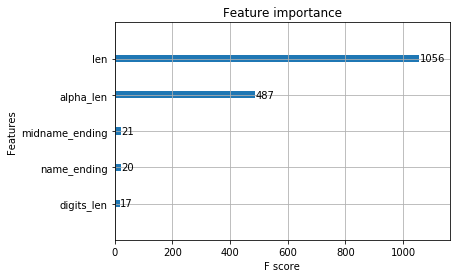

Learning :  target_phone
Accuracy score (validation): 0.999


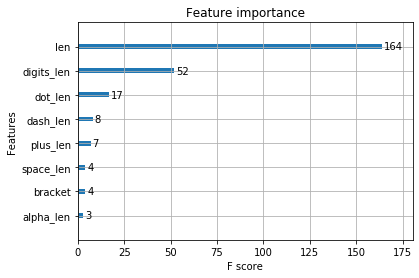

Learning :  target_surname
Accuracy score (validation): 0.947


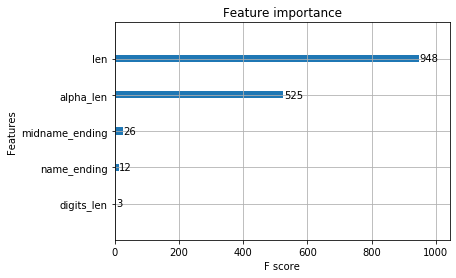

In [10]:
best_params = {'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}

xgb_clf = XGBClassifier(learning_rate=best_params['learning_rate'],
                        max_depth=best_params['max_depth'],
                        min_child_weight=best_params['min_child_weight'],
                        n_estimators = best_params['n_estimators'])

for column in y_train.columns:
    if (column !='target_other'):
        xgb_clf.fit(ROCtrainTRN, ROCtrainTRG[column])
        print("Learning : ", column)
        print("Accuracy score (validation): {0:.3f}".format(xgb_clf.score(ROCvalTRN, ROCvalTRG[column])))
        xgb_clf.fit(X_train, y_train[column])
        result[column]=predictions=(xgb_clf.predict_proba(X_test)[:,1])
        result[column]=(round(result[column],2))
        plot_importance(xgb_clf)
        plt.show()
    

In [11]:
result.to_csv(path+'result.csv',index=False, sep=';', encoding='cp1251')
